In [1]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet

## Define your alpha factor here

Spend your time in this cell, creating a good factor. Then simply run the rest of the notebook to analyze `factor_to_analyze`!

In [2]:
def make_pipeline():
    
    assets_moving_average = SimpleMovingAverage(inputs=[factset.Fundamentals.assets], window_length=252)
    current_assets = factset.Fundamentals.assets.latest
    
    factor_to_analyze = (current_assets - assets_moving_average)
    
    sector = Sector()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze, 'sector': sector},
        screen = QTradableStocksUS() & factor_to_analyze.notnull() & sector.notnull()
    )

factor_data = run_pipeline(make_pipeline(), '2015-1-1', '2016-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2015-1-1', '2016-6-1', fields='open_price')

## Create group neutral tear sheets

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.007,0.012,0.015
IC Std.,0.042,0.041,0.040
Risk-Adjusted IC,0.175,0.303,0.368
t-stat(IC),2.790,4.824,5.856
p-value(IC),0.006,0.000,0.000
IC Skew,-0.291,-0.293,-0.628
IC Kurtosis,0.792,-0.029,0.943


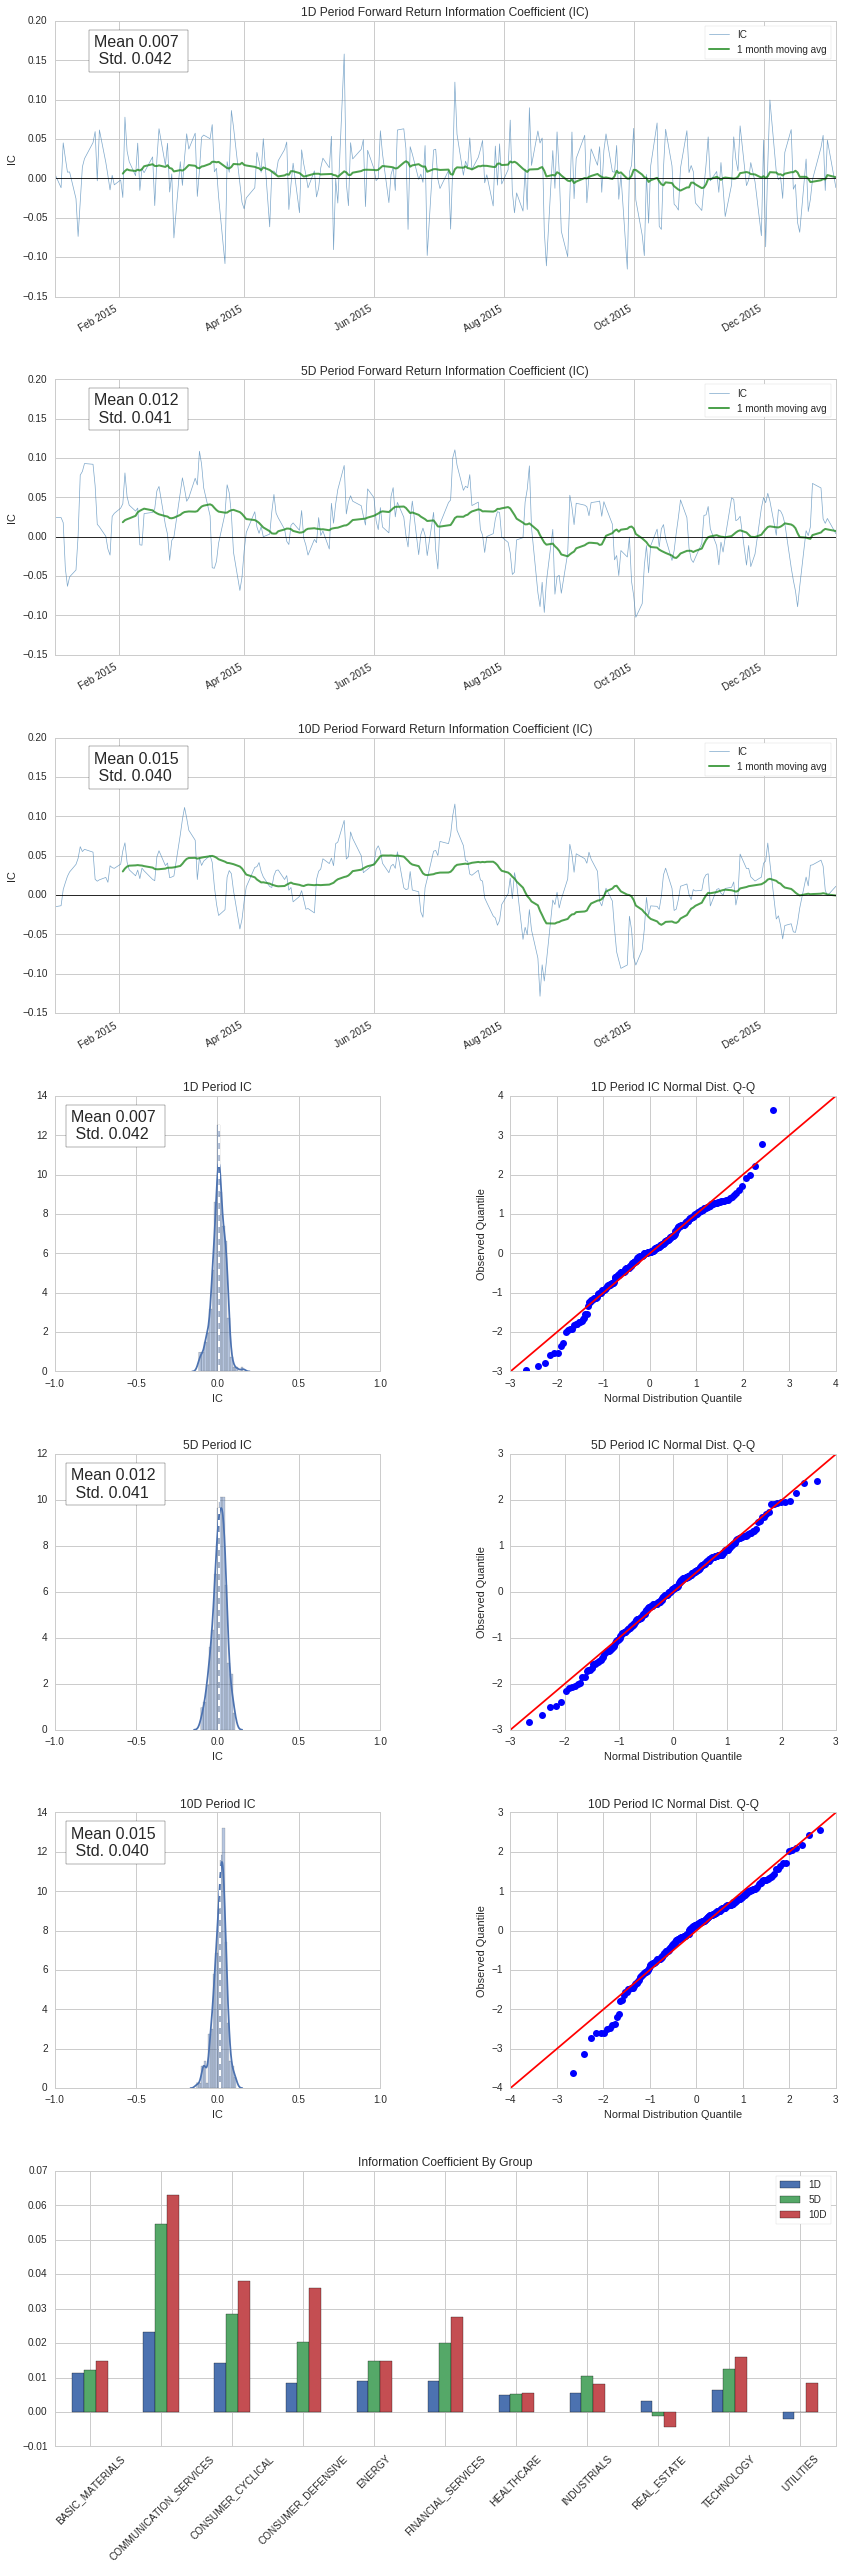

Returns Analysis


,1D,5D,10D
Ann. alpha,0.049,0.042,0.044
beta,-0.003,-0.021,-0.028
Mean Period Wise Return Top Quantile (bps),0.765,0.932,0.920
Mean Period Wise Return Bottom Quantile (bps),-1.092,-0.890,-0.894
Mean Period Wise Spread (bps),1.850,1.830,1.830


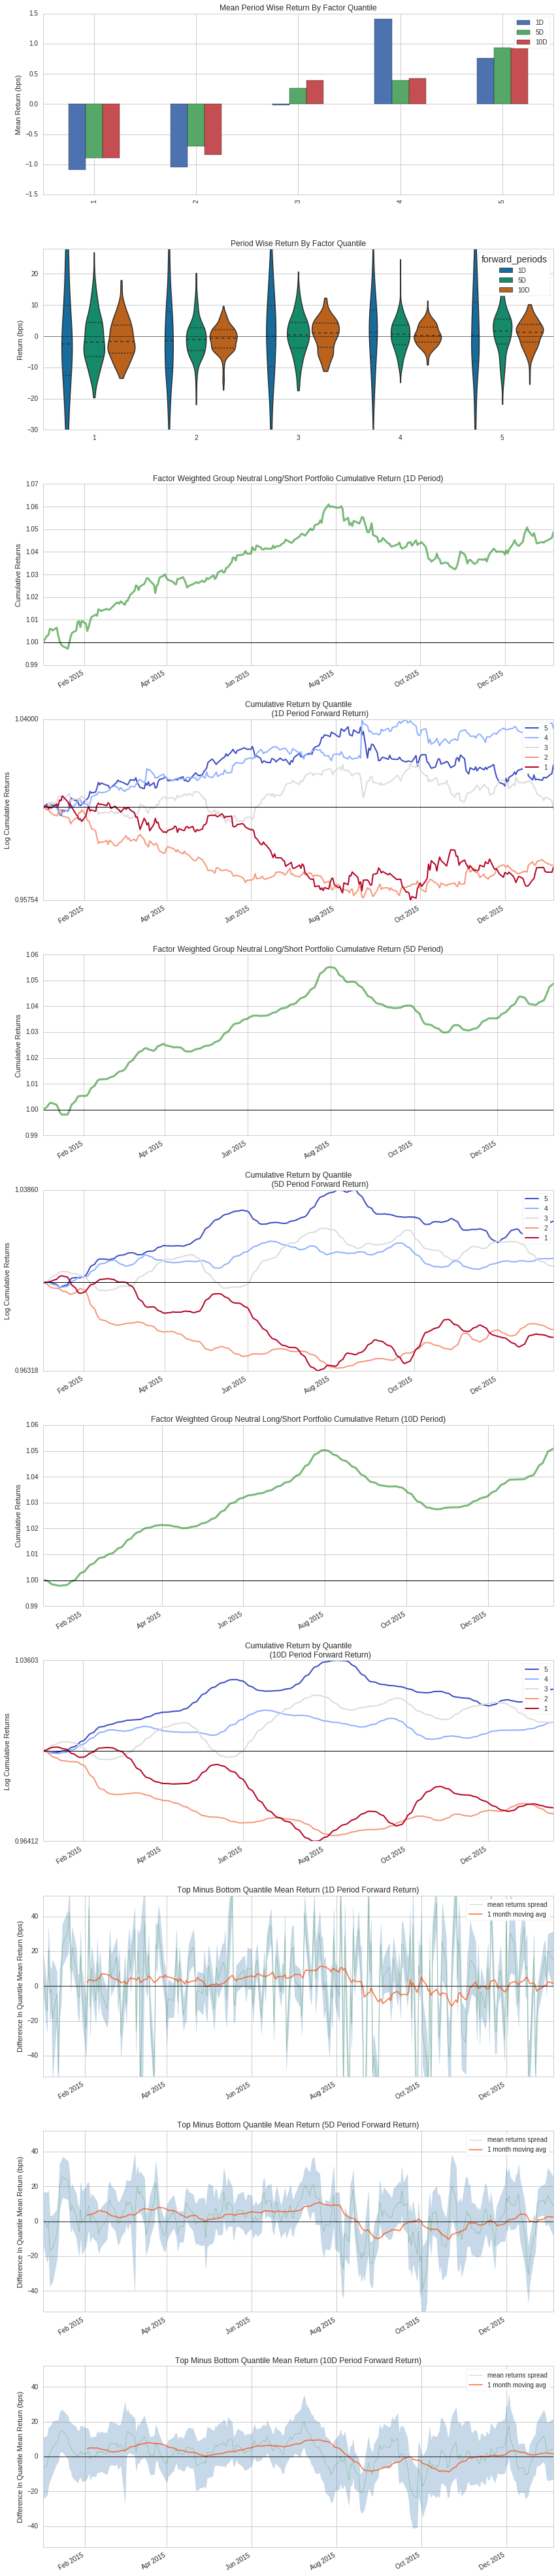

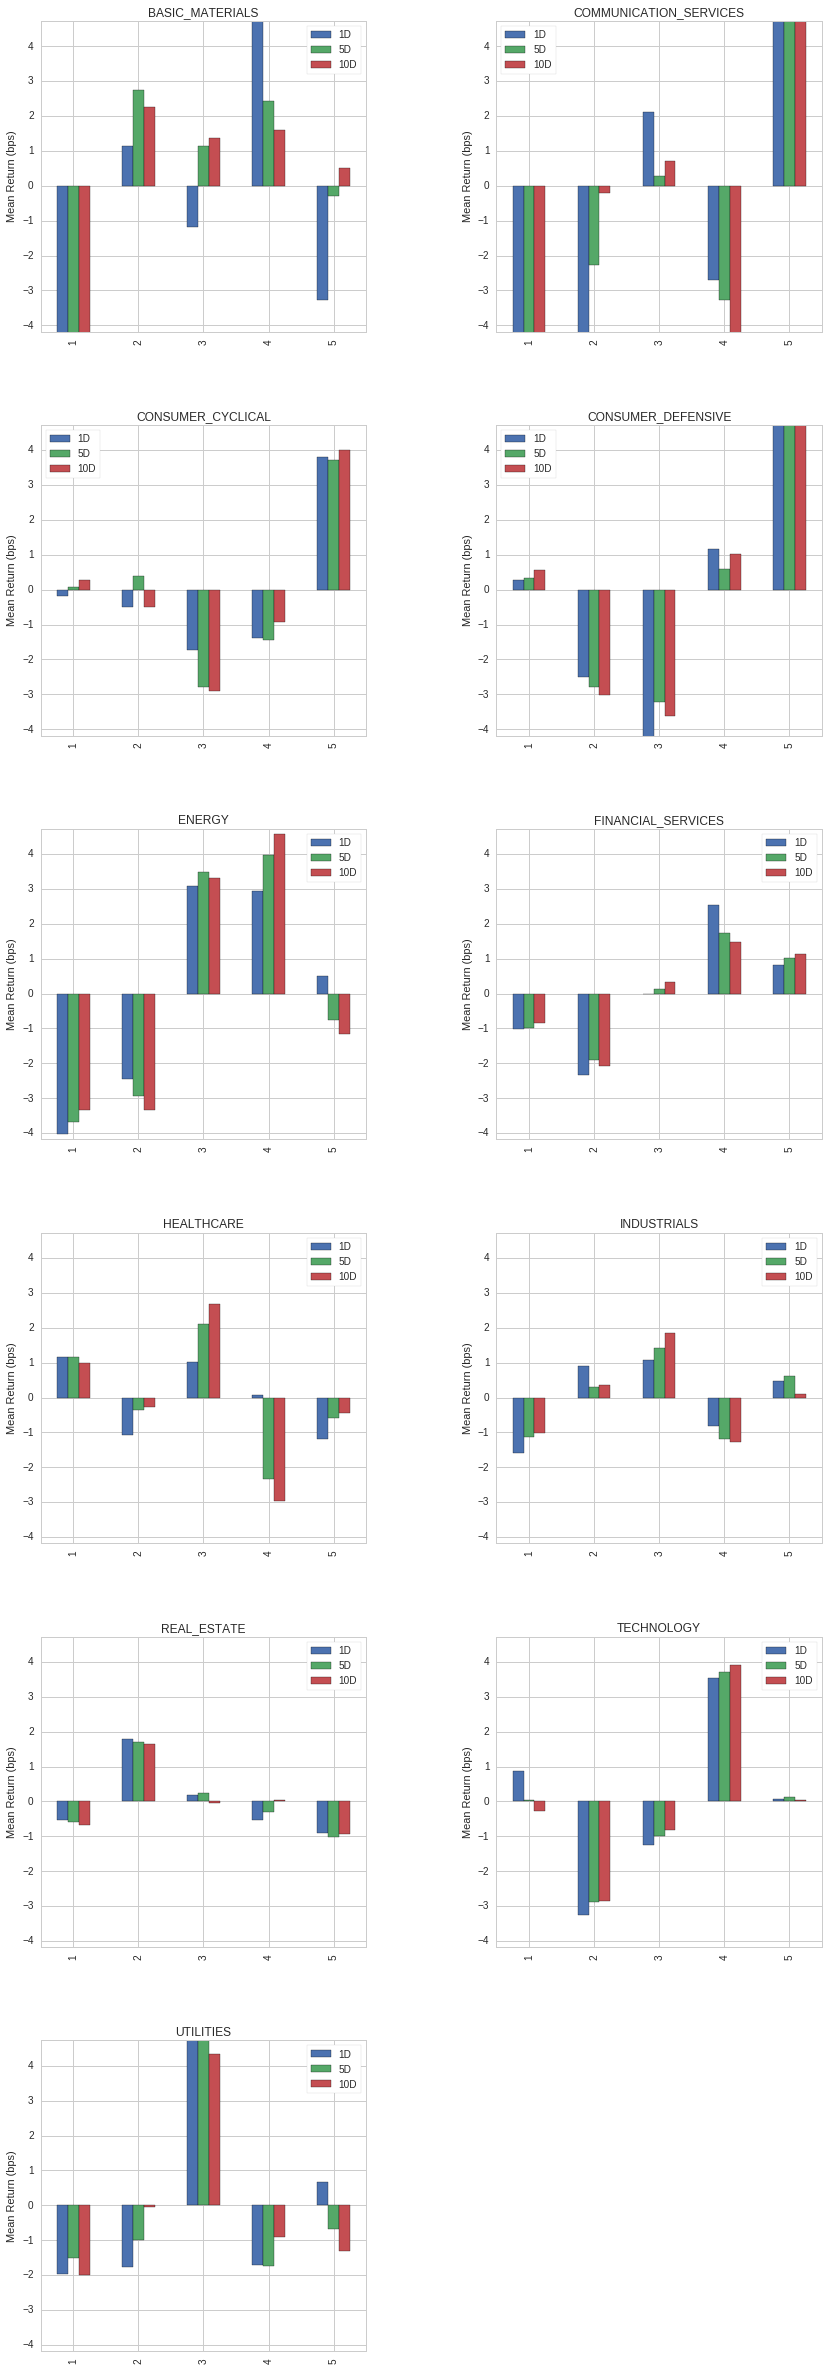

In [3]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    groupby = factor_data['sector'],
    groupby_labels = sector_labels,
    binning_by_group = True,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)

## Determine the decay rate of your alpha factor.

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


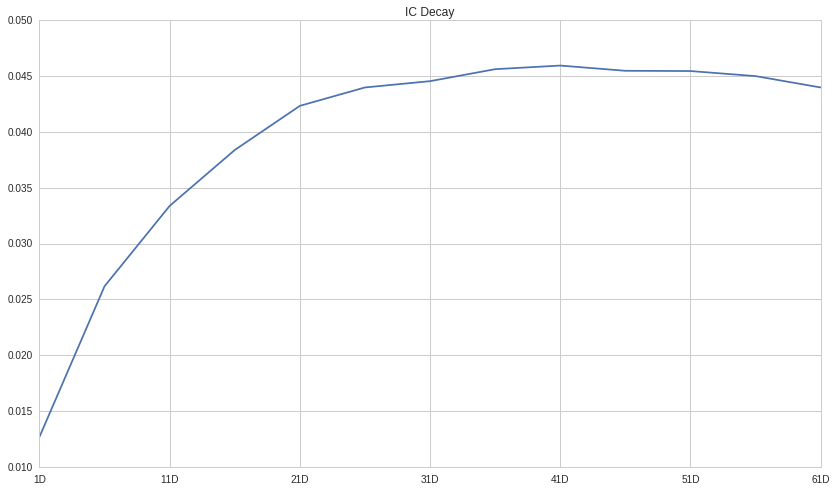

In [4]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")